<span style='font-family:sans-serif'> <font size="6">
CNN was successfully used to predict facial attractiveness from 1 to 5

<span style='font-family:sans-serif'> <font size="4">

(1) Import all data (5500 images)
    
* Data imported by name sorting using glob and PIL.Image libraries (OpenCV needs MacOS upgrade) 
* All 5500 images converted to numpy arrays, resulting in a single large (5500, 350,350,3) numpy array.
* Corresponding File names are saved in a list

(2) Create random 80/20 train-test split of large numpy array
* In prior step, all pixels were normalized to be between 0 and 1 by dividing by 255, the maximum value of channel.
* Using random seed, 4400 random numbers generated between 0 and 5499 because 80% of 5500 = 4400
* Above numbers were used as indices to select corresponding 4400 elements of large numpy array as X_train
* The rest of numbers were used to select X_test
    * Note: Names of files/images e.g. AF01.jpg were stored in a list/array called "names_train" and "names_test" 
* "All_labels.txt" contains average beauty score for each face. Create dictionary mapping image names to score. 


In [9]:
import numpy as np
import PIL
from PIL import Image
import glob, random
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from sklearn import metrics

In [4]:
data = []
names = []
files = sorted(glob.glob ("/Users/namita/Desktop/Milestone2/SCUT-FBP5500_v2/Images/*.jpg"))
for myFile in files:
    #image = cv2.imread (myFile)
    img = Image.open(myFile)
    img_nparray = np.asarray(img)
    
    data.append (img_nparray)
    img.close()
    names.append(myFile.split('/')[-1]) 
   
print('Data shape:', np.array(data).shape)
X = np.array(data)/255  # most important step for model convergance
print(names[:5])

Data shape: (5500, 350, 350, 3)
['AF1.jpg', 'AF10.jpg', 'AF100.jpg', 'AF1000.jpg', 'AF1001.jpg']


In [7]:
f = open('/Users/namita/Desktop/Milestone2/SCUT-FBP5500_v2/train_test_files/All_labels.txt', 'r') # import target variable
names_dict = {}
for line in f.readlines():
    L = line.split()
    names_dict[L[0]] = float(L[1])
#names_dict

y = [names_dict[imagename] for imagename in names]
y[:6]   # Optional: just to see 

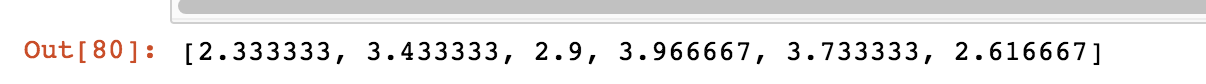

<span style='font-family:sans-serif'> <font size="4">
Now we have:
(1) All data before splitting called X with normalized pixel values. Super important

(2) target variable "y" which is a continuous quantitative variable

(3) dictionary of names called "names_dict" e.g. {"AF100.jpg", corresponding score}

<b> Note that X, y and names all correspond to each other position wise. i.e. if 0th image is AF1.jpg, then X[0] is the numpy array for X[0] and y[0] is the provided score from All_labels.txt file for Af1.jpg

In [6]:
random.seed(1)   # imp for reproducibility
train_indices = random.sample(range(0, 5500), 4400)
test_indices = [i for i in range(0,5499) if i not in train_indices]

# use above indices to make X_train, y_train, X_test and y_test
X_train, y_train, X_test,y_test,names_train,names_test = [],[],[],[],[],[]

for i in train_indices:
    X_train.append(X[i])
    y_train.append(y[i])
    names_train.append(names[i])

for j in test_indices:
    X_test.append(X[j])
    y_test.append(y[j])
    names_test.append(names[j])


In [7]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [8]:
names_train = np.array(names_train)
names_test = np.array(names_test)

<span style='font-family:sans-serif'> <font size="4">
    Don't delete begin. We are exporting the splitted train test and names of train and test dataframes into a .npz file to load if needed) --------------------------->

In [41]:
#np.savez_compressed('traintest.npz', X_train=X_train,y_train=y_train,X_test=X_test,y_test=y_test, names_train = names_train,names_test = names_test)

In [12]:
# traintest = np.load('traintest.npz')

In [8]:
#traintest.files

In [25]:
#traintest['names_test']

In [22]:
# X_train = traintest['X_train']
# X_test = traintest['X_test']
# y_train = traintest['y_train']
# y_test = traintest['y_test']

<span style='font-family:sans-serif'> <font size="4"> <---------------------------------Dont delete above ends

<span style='font-family:sans-serif'> <font size="6"> Built CNN

In [28]:
cnn = models.Sequential([
    # each filter is a feature detector. Convolving feature detector with original image gives feature map 
    layers.Conv2D(filters=100, kernel_size=(10, 10), activation='relu', input_shape=(350, 350, 3)),
    layers.MaxPooling2D((10, 10)),
    
    layers.Conv2D(filters=50, kernel_size=(10, 10), activation='relu'),
    layers.MaxPooling2D((10, 10)),
    
    # conventional ann
    layers.Flatten(),
    layers.Dense(30, activation='relu'),
    layers.Dense(10, activation='relu'),
    layers.Dense(1)
])

In [30]:
cnn.compile(optimizer='adam',
              loss="mean_squared_error",
              metrics=["mean_squared_error"])

In [31]:
cnn.fit(X_train, y_train, epochs=5)

Epoch 1/5
138/138 [==============================] - 1089s 8s/step - loss: 1.1239 - mean_squared_error: 1.1239
Epoch 2/5
138/138 [==============================] - 1068s 8s/step - loss: 0.4383 - mean_squared_error: 0.4383
Epoch 3/5
138/138 [==============================] - 1054s 8s/step - loss: 0.3408 - mean_squared_error: 0.3408
Epoch 4/5
138/138 [==============================] - 1049s 8s/step - loss: 0.2738 - mean_squared_error: 0.2738
Epoch 5/5
138/138 [==============================] - 1045s 8s/step - loss: 0.2424 - mean_squared_error: 0.2424


<span style='font-family:sans-serif'> <font size="4">
    Observations: MSE (mean squared error) decreases on every epoch indicating model is converging nicely. After 5 epochs, it was <b> 0.24 </b>.  Note that 1 epoch is 1 full pass. i.e. all 4400 training examples were fed, squared errors calculated for each example and mean square error was calculated. We could go beyond 5 epochs but it takes 20 minutes per epoch on my macbook, so we kept it reasonable  

In [32]:
cnn.evaluate(X_test,y_test)

35/35 [==============================] - 94s 3s/step - loss: 0.2153 - mean_squared_error: 0.2153


[0.2152998298406601, 0.2152998298406601]

<span style='font-family:sans-serif'> <font size="4">
    Observations: MSE for test set was <b> 0.21 </b> which is nice because It is comparable to (less than) training set and so we can say that we have generalized well without overfitting. Obviously, we'd want MSE should be 0 but that would be sure shot case of overfitting on training set. 

<span style='font-family:Arial'> <font size="4">
    <b> Interpretation: How good or bad is MSE of 0.21? </b> We could convert MSE into R2 value which would tells us what % of variance in dependent variable is explained by various features that our CNN extracted on its own! 
    
<span style='font-family:Arial'> <font size="4">
    To investigate, we created a dummy model which learns the mean beauty score of all training examples and for each new incoming test image, it just predicts the test face to be "AVERAGE" on beauty score! This seems an intuitively logical approach and not so dumb after all as most people in real life may well be average looking, neither too pretty, nor too ugly and also "mean reversion" is a strong force to reckon with!
    
<span style='font-family:Arial'> <font size="4">
    For dummy model, We calculate the average beauty of a face in training dataset np.mean(y_train) = 2.99 (i.e. 3.0). That value seems intuitively reasonable as that represents a face with nearly average beauty - what we would call a "typical" guy or girl in common parlance where "typical" means neither too pretty, nor too ugly. 

<span style='font-family:Arial'> <font size="4">
    So if our model always predicted 3.0 as the score for each new 1100 test images, then we would      basically have predictions like [3.0, 3.0, 3.0....................1100 times]
    
    
    

In [14]:
y_dummy = np.ones(1100)*3.0
y_test[:7]

array([2.333333, 2.9     , 2.7     , 2.783333, 3.316667, 2.866667,
       3.366667])

In [35]:
mse_dummy = metrics.mean_squared_error(y_test,y_dummy)
r2_dummy = metrics.r2_score(y_test,y_dummy)
print('Dummy model will have MSE of {}'.format(mse_dummy)  )
print('Dummy model will have R2 of {} %'.format(r2_dummy * 100 ) )

Dummy model will have MSE of 0.46676766868694275
Dummy model will have R2 of -0.0008569545993708516 %


<span style='font-family:sans-serif'> <font size="4">
    <b> R2 for dummy model = 0% </b> i.e. our dummy model is infact dumb! Just blindly predicting the average score each time will lead to terrible predictions and a HUGE mean square error of 0.47! 

In [26]:
y_predictions = cnn.predict(X_test)

In [38]:
mse_cnn = metrics.mean_squared_error(y_test,y_predictions)
r2_cnn = metrics.r2_score(y_test,y_predictions)
print('Our CNN will have MSE of {}'.format(mse_cnn)  )
print('Our CNN will have R2 of {} %'.format(r2_cnn * 100 ) )

Our CNN will have MSE of 0.21529984175413253
Our CNN will have R2 of 53.87390746627956 %


<span style='font-family:sans-serif'> <font size="4">
    <b> R2 for CNN is a whopping 54%! </b> It does remarkably well compared to the otherwise intuitive strategy of 
always predicting that every new user who signs up on our hypothetical dating site has "average" beauty. That is clearly not the case!

<span style='font-family:sans-serif'> <font size="4">This means that our CNN did a great job extracting features that were useful/meningful in explaining the variance in the beauty scores 

# -------------------------------------END------------------------------------------

<span style='font-family:sans-serif'> <font size="4">
    Optional but useful: Model was saved below using preferred method instead of the old .h5 file method


In [71]:
cnn.save("/Users/namita/Desktop/Milestone2/cnn_model_adi_chris")

INFO:tensorflow:Assets written to: /Users/namita/Desktop/Milestone2/cnn_model_adi_chris/assets


<span style='font-family:sans-serif'> <font size="4">
    Optional but useful: Model was loaded just to check if it loads fine, which it does

In [25]:
loadcheck = models.load_model("/Users/namita/Desktop/Milestone2/cnn_model_adi_chris")

In [73]:
type(loadcheck)

keras.engine.sequential.Sequential